In [1]:
import copy
from math import log
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
#add drive 

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
def loadDataSet():
    dataSet = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/P1_data.csv', delimiter=',')
    dataSet = dataSet.replace('yes', 1).replace('no', 0)
    labelSet = list(dataSet.columns.values)
    dataSet = dataSet.values
    return dataSet, labelSet


In [4]:
dataSet, labelSet=loadDataSet()
labelSet=labelSet[:4]
print(labelSet)
print(dataSet)

['outlook', 'temperature', 'humidity', 'windy']
[['sunny' 85 85 False 0]
 ['sunny' 80 90 True 0]
 ['overcast' 83 86 False 1]
 ['rainy' 70 96 False 1]
 ['rainy' 68 80 False 1]
 ['rainy' 65 70 True 0]
 ['overcast' 64 65 True 1]
 ['sunny' 72 95 False 0]
 ['sunny' 69 70 False 1]
 ['rainy' 75 80 False 1]
 ['sunny' 75 70 True 1]
 ['overcast' 72 90 True 1]
 ['overcast' 81 75 False 1]
 ['rainy' 71 91 True 0]]


The ID3, using information gain to build decision tree can only be applied to nominal data, so the first step here we preprocessing data.

In [5]:
def Impurity(X,Label,ClassNum = 1):
#partition functionm, based on gini
    Len = np.size(X)
    sX = np.sort(X)
    Tha = np.zeros(Len-1)
    gi = np.zeros(Len-1)
    for i in range(Len-1):
        Th = (sX[i] + sX[i+1])/2
        Tha[i] = Th
        idx1 = np.where(X < Th)
        idx2 = np.where(X >= Th)
        p = np.zeros([2,ClassNum])
        g = np.zeros([1,2])
        ww = np.zeros([2,1])
        for Ti in range(2):
            if Ti == 1:
                idxTP = idx1
            else:
                idxTP = idx2
            Lab = Label[idxTP]
            for cs in np.arange(1,ClassNum+1):
                if np.size(idxTP) == 0:
                    p[Ti,cs-1] = 0
                else:                        
                    p[Ti,cs-1] = np.size(np.where(Lab == cs)) / np.size(idxTP)
            g[0,Ti] = gini(p[Ti,:])
            ww[Ti,0] = np.size(idxTP) / Len
            gi[i] = np.dot(g,ww)
            del idxTP,Lab
    idxa = np.argmin(gi)
    ThA = Tha[idxa]
    impur = gi[idxa]
    return impur,ThA

def gini(p):
    if np.all(p == 0):
        g = 0
    else:
        g = 1 - np.sum(np.square(p))
    return g           

In [6]:
impur_temp,divide_point_tem=Impurity(dataSet[:,1],dataSet[:,4])
print("impurity=",impur_temp,"Best dividing point for temp:",divide_point_tem)
impur_hum,divide_point_hum=Impurity(dataSet[:,2],dataSet[:,4])
print("impurity=",impur_hum,"Best dividing point for hum:",divide_point_hum)

impurity= 0.4835164835164835 Best dividing point for temp: 84.0
impurity= 0.5408163265306123 Best dividing point for hum: 82.5


accoroding to the bi-partition result, the temperature should  be divided at the point 84.0, snf humidity should be divided at the pomint 82.5

In [8]:
def nominalize(x,divede_point,t): 
  r=[]
  if t==1:
    for i in x:
      if i<divede_point:
        r.append('t_low')
      else:
        r.append('t_high')
  else:
      for i in x:
        if i<divede_point:
          r.append('h_low')
        else:
          r.append('h_high')
  return r

In [9]:
dataSet[:,1]=nominalize(dataSet[:,1],divide_point_tem,t=1)

dataSet[:,2]=nominalize(dataSet[:,2],divide_point_hum,t=0)



Now we have new dataset 

In [10]:
print(labelSet)
print(dataSet)
Xdata=dataSet[:,:4]
ydata=dataSet[:,4]

['outlook', 'temperature', 'humidity', 'windy']
[['sunny' 't_high' 'h_high' False 0]
 ['sunny' 't_low' 'h_high' True 0]
 ['overcast' 't_low' 'h_high' False 1]
 ['rainy' 't_low' 'h_high' False 1]
 ['rainy' 't_low' 'h_low' False 1]
 ['rainy' 't_low' 'h_low' True 0]
 ['overcast' 't_low' 'h_low' True 1]
 ['sunny' 't_low' 'h_high' False 0]
 ['sunny' 't_low' 'h_low' False 1]
 ['rainy' 't_low' 'h_low' False 1]
 ['sunny' 't_low' 'h_low' True 1]
 ['overcast' 't_low' 'h_high' True 1]
 ['overcast' 't_low' 'h_low' False 1]
 ['rainy' 't_low' 'h_high' True 0]]


In [11]:
ydata

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0], dtype=object)


In this section, we implement methods for three kind of trees with different cretria: ID3 using information gain, C45 using gain ration and cary using gini index.

In [12]:
class DecisionTree(object):
    def __init__(self, decision_tree_type='CART', feature_list=None):
        self.decision_tree_type = decision_tree_type
        self.feature_list = feature_list

    @staticmethod
    def compute_entropy(x, y):
        """
        calculate info gain H(S) = -SUM(P*logP)
        :param x:
        :param y:
        :return:
        """
        sample_num = len(x)
        label_counter = Counter(y)
        dataset_entropy = 0.0
        for key in label_counter:
            prob = float(label_counter[key]) / sample_num
            dataset_entropy -= prob * log(prob, 2)  # get the log value

        return dataset_entropy

    def dataset_split_by_id3(self, x, y):
        """
        based on infomation gain
        :param x:
        :param y:
        :return:
        """
        feature_num = len(x[0])
        base_entropy = self.compute_entropy(x, y)
        best_info_gain, best_info_gain_ratio = 0.0, 0.0
        best_feature_idx = -1
        for i in range(feature_num):
            unique_features = set([example[i] for example in x])
            new_entropy, split_entropy = 0.0, 0.0
            for feature in unique_features:
                sub_dataset, sub_labels = [], []
                for featVec, label in zip(x, y):
                    if featVec[i] == feature:
                        sub_dataset.append(list(featVec[:i]) + list(featVec[i + 1:]))
                        sub_labels.append(label)

                prob = len(sub_dataset) / float(len(x))
                new_entropy += prob * self.compute_entropy(sub_dataset, sub_labels)

            info_gain = base_entropy - new_entropy
            if info_gain > best_info_gain:
                best_info_gain = info_gain
                best_feature_idx = i

        return best_feature_idx

    def dataset_split_by_c45(self, x, y):
        """
        based on gai ratio
        :param x:
        :param y:
        :return:
        """
        feature_num = len(x[0])
        base_entropy = self.compute_entropy(x, y)
        best_info_gain, best_info_gain_ratio = 0.0, 0.0
        best_feature_idx = -1
        for i in range(feature_num):
            unique_features = set([example[i] for example in x])
            new_entropy, split_entropy = 0.0, 0.0
            for feature in unique_features:
                sub_dataset, sub_labels = [], []
                for featVec, label in zip(x, y):
                    if featVec[i] == feature:
                        sub_dataset.append(list(featVec[:i]) + list(featVec[i + 1:]))
                        sub_labels.append(label)

                prob = len(sub_dataset) / float(len(x))
                new_entropy += prob * self.compute_entropy(sub_dataset, sub_labels)

                split_entropy += -prob * log(prob, 2)

            info_gain = base_entropy - new_entropy
            info_gain_ratio = info_gain / split_entropy if split_entropy else 0.0
            if info_gain_ratio > best_info_gain_ratio:
                best_info_gain_ratio = info_gain_ratio
                best_feature_idx = i

        return best_feature_idx

    def create_tree_by_id3_and_c45(self, x, y, feature_list=None):
        """
        bulid tree
        :param x:
        :param y:
        :param feature_list:
        :return:
        """
        # the type is the same, so stop classify
        if len(set(y)) <= 1:
            return y[0]
        # traversal all the features and choose the most frequent feature
        if len(x[0]) == 1:
            return Counter(y).most_common(1)

        feature_list = [i for i in range(len(y))] if not feature_list else feature_list
        if self.decision_tree_type == 'ID3':
            best_feature_idx = self.dataset_split_by_id3(x, y)
        elif self.decision_tree_type == 'C45':
            best_feature_idx = self.dataset_split_by_c45(x, y)
        else:
            raise KeyError
        decision_tree = {best_feature_idx: {}}
        feature_list = feature_list[:best_feature_idx] + feature_list[best_feature_idx + 1:]
        # get the list which attain the whole properties
        best_feature_values = set([sample[best_feature_idx] for sample in x])
        for value in best_feature_values:
            sub_dataset, sub_labels = [], []
            for featVec, label in zip(x, y):
                if featVec[best_feature_idx] == value:
                    sub_dataset.append(list(featVec[:best_feature_idx]) + list(featVec[best_feature_idx + 1:]))
                    sub_labels.append(label)

            decision_tree[best_feature_idx][value] = self.create_tree_by_id3_and_c45(sub_dataset, sub_labels, feature_list)

        return decision_tree

    @staticmethod
    def compute_gini(x, y):
        """
        :param x: dataset
        :param y: labal
        :return:gini index
        """
        unique_labels = set(y)
        sample_num = len(x)  # y
        gini = 1.0
        for label in unique_labels:
            gini_k = len(x[y == label]) / sample_num  #frequnecy
            gini -= gini_k ** 2
        return gini

    def dataset_split_by_cart(self, x, y):
        """
        based in gini
        :param x:
        :param y:
        :return:
        """
        sample_num, feature_num = x.shape
        column_feature_gini = {}  
        for i in range(feature_num):  
            column_i = dict(Counter(x[:, i]))  
            for value in column_i.keys(): 
                best_flag = 1.00001
                cls_same, cls_diff = x[:, i] == value, x[:, i] != value
                sub_x1, sub_y1 = x[cls_same], y[cls_same]
                sub_x2, sub_y2 = x[cls_diff], y[cls_diff]
                sublen1, sublen2 = len(sub_x1), len(sub_x2)
                if (sublen1 / sample_num) * self.compute_gini(sub_x1, sub_y1) == 0:
                    best_flag = 1
                feaGini = (sublen1 / sample_num) * self.compute_gini(sub_x1, sub_y1) + \
                          (sublen2 / sample_num) * self.compute_gini(sub_x2, sub_y2)
                column_feature_gini[(i, value)] = feaGini * best_flag

        # find out smellest gini index row
        best_feature_and_idx = min(column_feature_gini, key=column_feature_gini.get)

        return best_feature_and_idx, column_feature_gini

    def create_tree_by_cart(self, x, y, feature_list=None):

        y_lables = np.unique(y)

        if len(set(y_lables)) == 1:
            return y_lables[0]

    
        if len(x[0]) == 0:
            labelCount = dict(Counter(y_lables))
            return max(labelCount, key=labelCount.get)

        best_feature_and_idx, _ = self.dataset_split_by_cart(x, y)

        feature_list = [i for i in range(len(x[0]))] if not feature_list else feature_list
        best_feature_idx = feature_list[int(best_feature_and_idx[0])] 

        decision_tree = {best_feature_idx: {}}  
        feature_list.pop(int(best_feature_and_idx[0]))

      
        y_lables_split = y[list(x[:, int(best_feature_and_idx[0])] == best_feature_and_idx[1])] 
        y_lables_grp = Counter(y_lables_split)  
        y_leaf = y_lables_grp.most_common(1)[0][0] 
        decision_tree[best_feature_idx][best_feature_and_idx[1]] = y_leaf 

       
        sub_x = np.delete(x, int(best_feature_and_idx[0]), axis=1)  
 
        y1 = y_lables[0] 
        y2 = y_lables[1]
        if y_leaf == y1:
            decision_tree[best_feature_idx][y2] = self.create_tree_by_cart(sub_x, y, feature_list)
        elif y_leaf == y2:
            decision_tree[best_feature_idx][y1] = self.create_tree_by_cart(sub_x, y, feature_list)

        return decision_tree

    def train(self, x, y):
        x, y = np.array(x), np.array(y)
        if self.decision_tree_type in ('ID3', 'C45'):
            return self.create_tree_by_id3_and_c45(x, y, feature_list=copy.deepcopy(self.feature_list))
        elif self.decision_tree_type == 'CART':
            return self.create_tree_by_cart(x, y, feature_list=copy.deepcopy(self.feature_list))
        else:
            raise KeyError

    def predict(self, tree, x):
        """
        tree predic 
        :param tree:
        :param x:
        :return:
        """
        root = list(tree.keys())[0]
        root_dict = tree[root]
        for key, value in root_dict.items():
            if x[root if not self.feature_list else self.feature_list.index(root)] == key:
                if isinstance(value, dict):
                    _label = self.predict(value, x)
                else:
                    _label = value

                return _label

        raise KeyError

    def getNumLeafs(self, myTree):
        numLeafs = 0
        firstStr = list(myTree.keys())[0]
        secondDict = myTree[firstStr]
        for key in secondDict.keys():
            if isinstance(secondDict[key], dict):  # test to see if the nodes are dictonaires, if not they are leaf nodes
                numLeafs += self.getNumLeafs(secondDict[key])
            else:
                numLeafs += 1
        return numLeafs

    def getTreeDepth(self, myTree):
        maxDepth = 0
        firstStr = list(myTree.keys())[0]  # myTree.keys()[0]
        secondDict = myTree[firstStr]
        for key in secondDict.keys():
            if isinstance(secondDict[key], dict):  # test to see if the nodes are dictonaires, if not they are leaf nodes
                thisDepth = 1 + self.getTreeDepth(secondDict[key])
            else:
                thisDepth = 1
            if thisDepth > maxDepth: maxDepth = thisDepth
        return maxDepth

    def plotNode(self, nodeTxt, centerPt, parentPt, nodeType):
        self.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction',
                                xytext=centerPt, textcoords='axes fraction',
                                va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)

    def plotMidText(self, cntrPt, parentPt, txtString):
        xMid = (parentPt[0] - cntrPt[0]) / 2.0 + cntrPt[0]
        yMid = (parentPt[1] - cntrPt[1]) / 2.0 + cntrPt[1]
        self.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

    def plotTree(self, myTree, parentPt, nodeTxt):  # if the first key tells you what feat was split on
        numLeafs = self.getNumLeafs(myTree)  # this determines the x width of this tree
        # depth = getTreeDepth(myTree)
        firstStr = list(myTree.keys())[0]  # myTree.keys()[0]     #the text label for this node should be this
        cntrPt = (self.xOff + (1.0 + float(numLeafs)) / 2.0 / self.totalW, self.yOff)
        self.plotMidText(cntrPt, parentPt, nodeTxt)
        self.plotNode(firstStr, cntrPt, parentPt, decisionNode)
        secondDict = myTree[firstStr]
        self.yOff = self.yOff - 1.0 / self.totalD
        for key in secondDict.keys():
            if isinstance(secondDict[key], dict):  # test to see if the nodes are dictonaires, if not they are leaf nodes
                self.plotTree(secondDict[key], cntrPt, str(key))  # recursion
            else:  # it's a leaf node print the leaf node
                self.xOff = self.xOff + 1.0 / self.totalW
                self.plotNode(secondDict[key], (self.xOff, self.yOff), cntrPt, leafNode)
                self.plotMidText((self.xOff, self.yOff), cntrPt, str(key))
        self.yOff = self.yOff + 1.0 / self.totalD

    def createPlot(self, myTree):
        fig = plt.figure(1, facecolor='white')
        fig.clf()
        axprops = dict(xticks=[], yticks=[])
        self.ax1 = plt.subplot(111, frameon=False, **axprops)  # no ticks
        # createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses
        self.totalW = float(self.getNumLeafs(myTree))
        self.totalD = float(self.getTreeDepth(myTree))
        self.xOff = -0.5 / self.totalW
        self.yOff = 1.0
        self.plotTree(myTree, (0.5, 1.0), '')
        plt.show()


In [13]:
labelSet

['outlook', 'temperature', 'humidity', 'windy']

{'outlook': {'overcast': 1, 0: {'humidity': {'h_high': 0, 1: {'temperature': {'t_high': 0, 1: {'windy': {False: 0}}}}}}}}


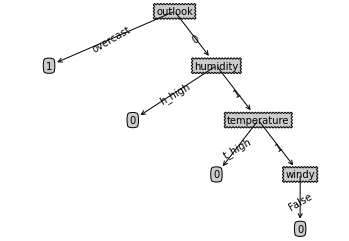

In [14]:
dt_cart = DecisionTree(decision_tree_type='CART',feature_list=labelSet)
cartTree = dt_cart.train(Xdata, ydata)
print(cartTree)
dt_cart.createPlot(cartTree)
#gini index tree

{0: {'sunny': {1: {'h_high': 0, 'h_low': 1}}, 'rainy': {2: {False: 1, True: 0}}, 'overcast': 1}}


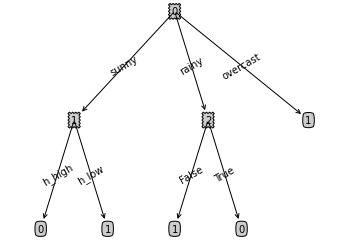

In [15]:
dt_ID3 = DecisionTree(decision_tree_type='ID3',feature_list=labelSet)
ID3Tree = dt_ID3.train(Xdata, ydata)
print(ID3Tree)
dt_ID3.createPlot(ID3Tree)
#information gain tree

{1: {'t_high': 0, 't_low': {0: {'sunny': {0: {'h_high': 0, 'h_low': 1}}, 'rainy': {1: {False: 1, True: 0}}, 'overcast': 1}}}}


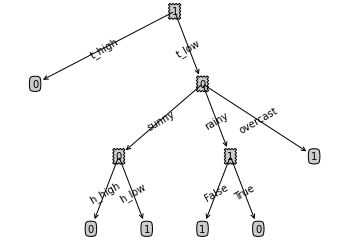

In [16]:
dt_C45 = DecisionTree(decision_tree_type='C45',feature_list=labelSet)
C45Tree = dt_C45.train(Xdata, ydata)
print(C45Tree)
dt_C45.createPlot(C45Tree)
# gain ratio tree

In [17]:
labelSet

['outlook', 'temperature', 'humidity', 'windy']

In [18]:
test=['overcast','t_low','h_low','false']

In [19]:
predict2 = dt_cart.predict(cartTree, test)
print(predict2)

1


using gini as cariteria to test the new example, we have the ressult, yes.